# Uppgift 0

In [119]:
import pandas as pd
import seaborn as sns
import hashlib as hl
import matplotlib.pyplot as plt
import numpy as np
from functools import cache
import sys
sys.path.append("..")
from data_utils import *
import matplotlib.image as mpimg

# def hash_column(df, column): 
#     '''
#     TODO fix settingwithcopywarning
#     anonymizes specified column on passed df
#     drops specified column
#     returns modified df
#     '''
#     hashed_column= df[column].apply(lambda row_value: hl.sha256(row_value.encode()).hexdigest())
#     df.insert(1,"Name(Hash Value)", hashed_column)
#     df = df.drop(columns=[column])
#     return df


df = pd.read_csv("../athlete_events.csv")
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [120]:
# A

noc = df["NOC"].nunique()
print(noc)

230


In [121]:
# B

noc_list = [x for x in df["NOC"].unique()]
print(noc_list)

['CHN', 'DEN', 'NED', 'USA', 'FIN', 'NOR', 'ROU', 'EST', 'FRA', 'MAR', 'ESP', 'EGY', 'IRI', 'BUL', 'ITA', 'CHA', 'AZE', 'SUD', 'RUS', 'ARG', 'CUB', 'BLR', 'GRE', 'CMR', 'TUR', 'CHI', 'MEX', 'URS', 'NCA', 'HUN', 'NGR', 'ALG', 'KUW', 'BRN', 'PAK', 'IRQ', 'UAR', 'LIB', 'QAT', 'MAS', 'GER', 'CAN', 'IRL', 'AUS', 'RSA', 'ERI', 'TAN', 'JOR', 'TUN', 'LBA', 'BEL', 'DJI', 'PLE', 'COM', 'KAZ', 'BRU', 'IND', 'KSA', 'SYR', 'MDV', 'ETH', 'UAE', 'YAR', 'INA', 'PHI', 'SGP', 'UZB', 'KGZ', 'TJK', 'EUN', 'JPN', 'CGO', 'SUI', 'BRA', 'FRG', 'GDR', 'MON', 'ISR', 'URU', 'SWE', 'ISV', 'SRI', 'ARM', 'CIV', 'KEN', 'BEN', 'UKR', 'GBR', 'GHA', 'SOM', 'LAT', 'NIG', 'MLI', 'AFG', 'POL', 'CRC', 'PAN', 'GEO', 'SLO', 'CRO', 'GUY', 'NZL', 'POR', 'PAR', 'ANG', 'VEN', 'COL', 'BAN', 'PER', 'ESA', 'PUR', 'UGA', 'HON', 'ECU', 'TKM', 'MRI', 'SEY', 'TCH', 'LUX', 'MTN', 'CZE', 'SKN', 'TTO', 'DOM', 'VIN', 'JAM', 'LBR', 'SUR', 'NEP', 'MGL', 'AUT', 'PLW', 'LTU', 'TOG', 'NAM', 'AHO', 'ISL', 'ASA', 'SAM', 'RWA', 'DMA', 'HAI', 'MLT'

In [122]:
# C

sports = [x for x in df["Sport"].unique()]
print(sports)

['Basketball', 'Judo', 'Football', 'Tug-Of-War', 'Speed Skating', 'Cross Country Skiing', 'Athletics', 'Ice Hockey', 'Swimming', 'Badminton', 'Sailing', 'Biathlon', 'Gymnastics', 'Art Competitions', 'Alpine Skiing', 'Handball', 'Weightlifting', 'Wrestling', 'Luge', 'Water Polo', 'Hockey', 'Rowing', 'Bobsleigh', 'Fencing', 'Equestrianism', 'Shooting', 'Boxing', 'Taekwondo', 'Cycling', 'Diving', 'Canoeing', 'Tennis', 'Modern Pentathlon', 'Figure Skating', 'Golf', 'Softball', 'Archery', 'Volleyball', 'Synchronized Swimming', 'Table Tennis', 'Nordic Combined', 'Baseball', 'Rhythmic Gymnastics', 'Freestyle Skiing', 'Rugby Sevens', 'Trampolining', 'Beach Volleyball', 'Triathlon', 'Ski Jumping', 'Curling', 'Snowboarding', 'Rugby', 'Short Track Speed Skating', 'Skeleton', 'Lacrosse', 'Polo', 'Cricket', 'Racquets', 'Motorboating', 'Military Ski Patrol', 'Croquet', 'Jeu De Paume', 'Roque', 'Alpinism', 'Basque Pelota', 'Aeronautics']


In [123]:
# D

medals = [x for x in df["Medal"].unique()]
print(medals)

[nan, 'Gold', 'Bronze', 'Silver']


In [124]:
# E

display(df["Age"].describe())
display(df["Age"].median())

count    261642.000000
mean         25.556898
std           6.393561
min          10.000000
25%          21.000000
50%          24.000000
75%          28.000000
max          97.000000
Name: Age, dtype: float64

np.float64(24.0)

In [125]:
# F 



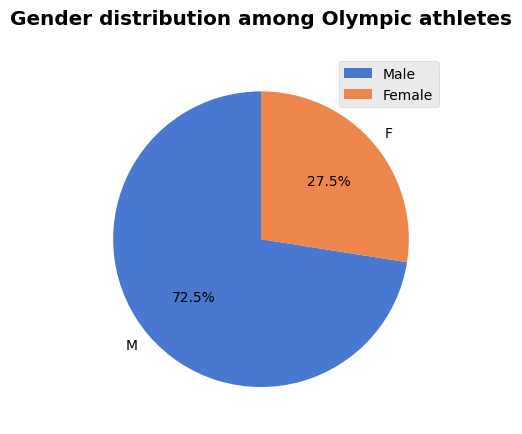

In [126]:
# G

# pal = {"F": "lime", "M": "yellow"}
sex_counts = df["Sex"].value_counts()
sex_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("muted"))#, palette=pal)
plt.ylabel("")
plt.title("Gender distribution among Olympic athletes\n", fontweight="bold")
plt.legend(["Male", "Female"])
plt.show()

In [127]:
# # H

# dfnm = df[["NOC", "Medal"]]
# dfnm = dfnm.dropna(how="any")
# display(dfnm)
# noc_list = [x for x in dfnm["NOC"].unique()]

In [128]:
# # Detta måste gå att göra på något mer effektivt sätt pga tar 57 sek

# def count_medals_per_unique_column_value(): # gör om för att ta emot arg
#     medal_list = []
#     for noc in noc_list:
#         counter = 0
#         for index in range(len(dfnm["NOC"])):
#             if noc == dfnm.iloc[index, 0]:
#                 counter += 1
#         medal_list.append(counter)
#     return medal_list


# medal_list = count_medals_per_unique_column_value()

In [129]:
# df_winners = pd.DataFrame({
#     "Country": np.array(noc_list),
#     "Medals": np.array(medal_list)})

# df_winners = df_winners.sort_values(by="Medals", ascending=False)

# display(df_winners.head(10))

In [130]:
df_medals = df.dropna(subset=["Medal"])
medal_count = df_medals["NOC"].value_counts()
top10 = medal_count.sort_values(ascending=False)#.head(10)
# sns.barplot(x=top10.index, y=top10, palette="muted")
display(top10)

NOC
USA    5637
URS    2503
GER    2165
GBR    2068
FRA    1777
       ... 
GAB       1
DJI       1
ERI       1
BAR       1
TGA       1
Name: count, Length: 149, dtype: int64

In [131]:
df_medals = df.dropna(subset=["Medal"]) # removes nans in medal column

medal_counts = df_medals.groupby(["NOC", "Medal"]).size().unstack(fill_value=0)
medal_counts

Medal,Bronze,Gold,Silver
NOC,,,
AFG,2,0,0
AHO,0,0,1
ALG,8,5,4
ANZ,5,20,4
ARG,91,91,92
...,...,...,...
VIE,0,1,3
WIF,5,0,0
YUG,93,130,167


In [132]:
# I

# Uppgift 1

In [133]:
df_anon = df.copy()
hashes = df_anon["Name"].apply(lambda name: hl.sha256(name.encode()).hexdigest())
df_anon.insert(1, "Hash", hashes)
df_anon = df_anon.drop(columns=["Name"])
df_anon.head()

,ID,Hash,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,3a4eef48434c66b3f14ab0221f6762d0ef7c6135ab2790...,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,a6430cc6630934275dc6283f7e97e9625e6587cdddec7a...,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,9c198b205332c2c8e1542e0f9534b9e270780a41d978ec...,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,0a477bb1c5ad39716f9c775e54d18d16aa8b37ada55548...,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,5b7be356aa28178096dc6747f0b8e4e393eaceb5f95310...,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [134]:
no = df_anon[df_anon["NOC"] == "NOR"].copy()

In [135]:
no_elite = no[["Sport", "Medal"]] 
# nu borde det kunna gå att använda count_medals_per_unique_column_value()
no_elite

,Sport,Medal
59,Alpine Skiing,NaN
60,Alpine Skiing,Gold
61,Alpine Skiing,Bronze
62,Alpine Skiing,NaN
63,Alpine Skiing,Silver
...,...,...
270398,Rhythmic Gymnastics,NaN
270674,Ice Hockey,NaN
270675,Ice Hockey,NaN
271017,Shooting,NaN


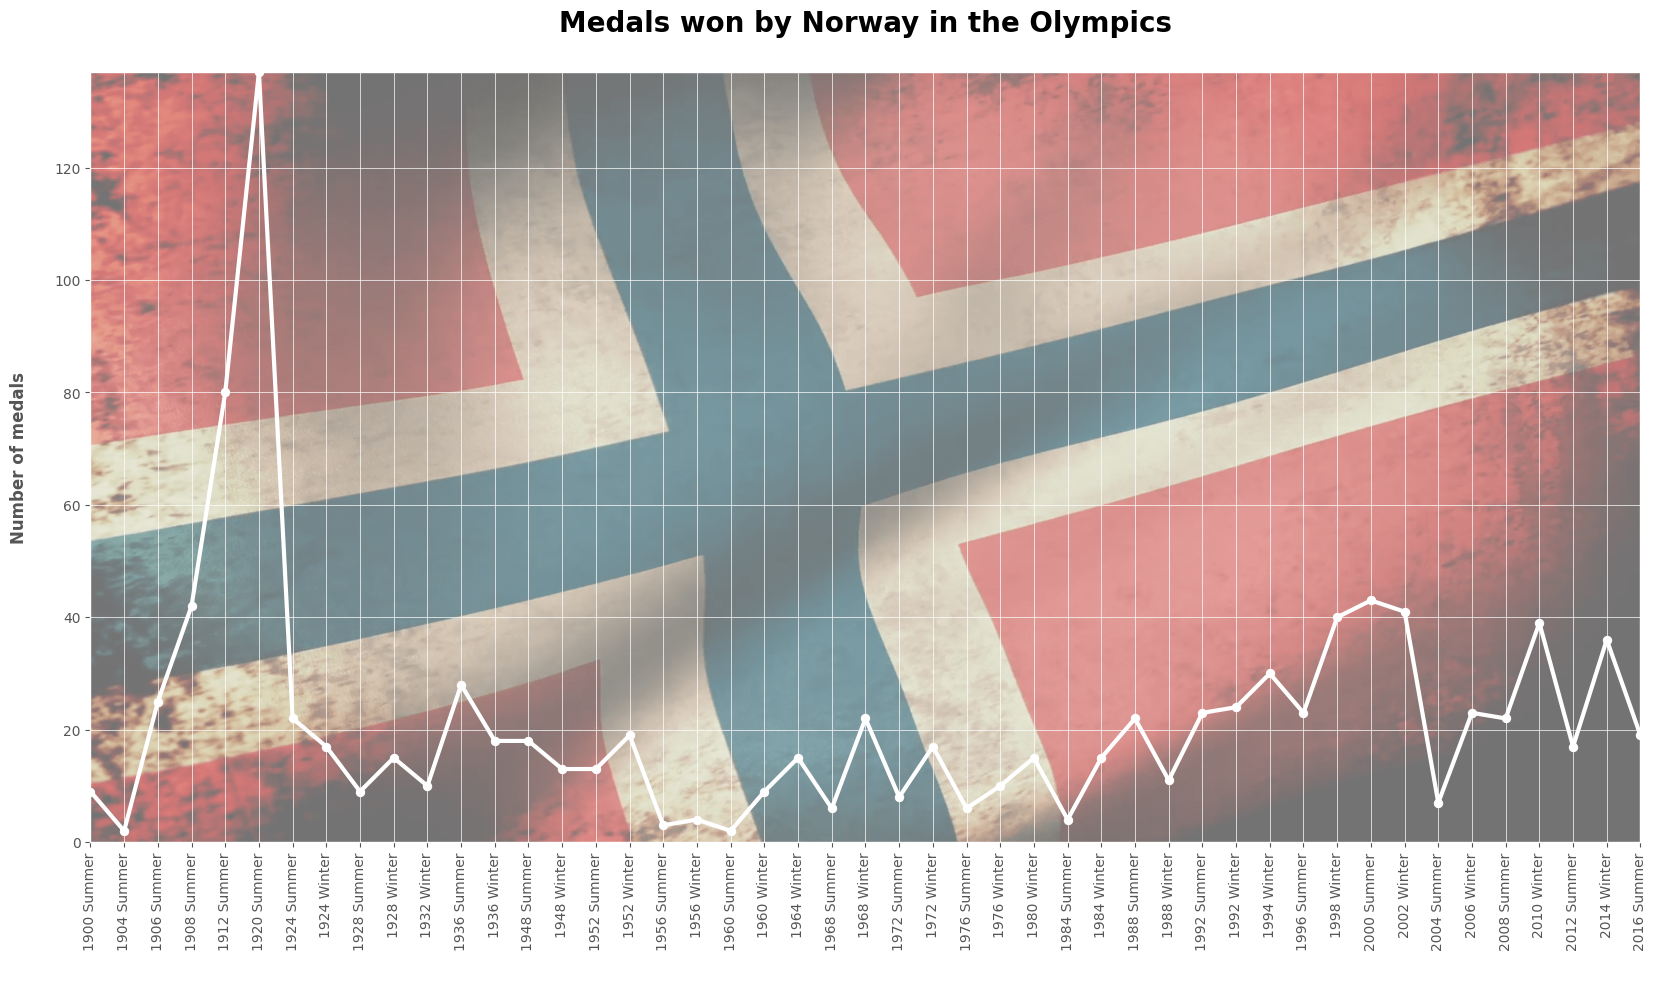

In [136]:
bg_image = mpimg.imread('nor.png')
medals_by_games = group_medals(no, "Games").sort_values(by="Games")
# display(medals_by_games)
plt.figure(figsize=(20, 10))
plt.imshow(bg_image, extent=[0, len(medals_by_games["Total"]) - 1, 0, medals_by_games["Total"].max()], aspect='auto', zorder=-1, alpha=0.5)
sns.lineplot(data=medals_by_games, x="Games", y="Total", marker="o", color="white", linewidth=3)
plt.title("Medals won by Norway in the Olympics\n", fontweight="bold", fontsize=20)
plt.xlabel(" ")
plt.ylabel("Number of medals\n", fontweight="bold")
plt.xticks(rotation=90)
plt.show()

In [137]:
uni_games = [x for x in no["Games"].unique()]
uni_games.sort()
print(uni_games)

['1900 Summer', '1904 Summer', '1906 Summer', '1908 Summer', '1912 Summer', '1920 Summer', '1924 Summer', '1924 Winter', '1928 Summer', '1928 Winter', '1932 Summer', '1932 Winter', '1936 Summer', '1936 Winter', '1948 Summer', '1948 Winter', '1952 Summer', '1952 Winter', '1956 Summer', '1956 Winter', '1960 Summer', '1960 Winter', '1964 Summer', '1964 Winter', '1968 Summer', '1968 Winter', '1972 Summer', '1972 Winter', '1976 Summer', '1976 Winter', '1980 Winter', '1984 Summer', '1984 Winter', '1988 Summer', '1988 Winter', '1992 Summer', '1992 Winter', '1994 Winter', '1996 Summer', '1998 Winter', '2000 Summer', '2002 Winter', '2004 Summer', '2006 Winter', '2008 Summer', '2010 Winter', '2012 Summer', '2014 Winter', '2016 Summer']


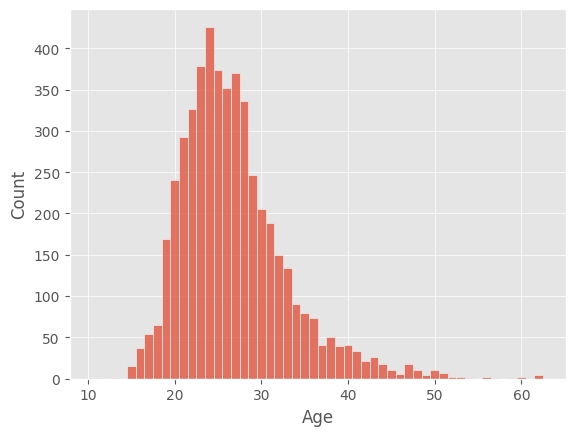

In [138]:
sns.histplot(data=no, x="Age", discrete=True)

plt.show()

## Gender distribution  

### Perhaps  
* age  
* medals  
* px subplot pie chart of women w/ medals vs women participating, same for men  
* sns barplot (countplot?) of women particiapting through the years
* best sports

<Axes: xlabel='Age', ylabel='Count'>

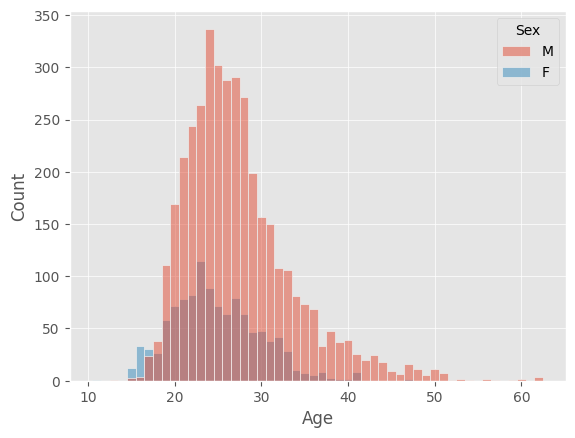

In [139]:
no_fem = no[no["Sex"] == "F"]
no_man = no[no["Sex"] == "M"]

sns.histplot(data=no, x="Age", discrete=True, color="pink", hue="Sex")

In [140]:
# chatGPT (only incorrect in 1908 and 1920)
# no = df[df["NOC"] == "NOR"]
# no_medals = no[no["Medal"].notnull()]
# no_medals = no_medals.drop_duplicates(subset=["Games", "Event"])
# medal_counts = no_medals.groupby(["Year", "Season"])["Medal"].count().reset_index(name="Medal Count")
# display(medal_counts)

# Philip
# no = df[df["NOC"] == "NOR"]
# no_medals = no[no["Medal"].notnull()]
# no_medals = no_medals.drop_duplicates(subset=["Event", "Games", "Team"])
# no_medals = no_medals[no_medals["Games"] == "1920 Summer"]
# no_medals.info()
# display(no_medals)

# chatGPT refined
# no = df[df["NOC"] == "NOR"]
# norway_medals_df = no[no['Medal'].notnull()]
# norway_unique_medals_df = norway_medals_df.drop_duplicates(subset=['Games', 'Event', 'Team'])
# medal_counts = norway_unique_medals_df.groupby(['Year', 'Season'])['Medal'].count().reset_index(name='Medal Count')
# medal_counts = medal_counts.sort_values(by=['Year', 'Season']).reset_index(drop=True)
# display(medal_counts)


In [157]:
no = df[df["NOC"] == "NOR"]
no_medals_32 = no[no["Medal"].notnull()]
no_medals_32 = no_medals_32.drop_duplicates(subset=["Event", "Games", "Medal", "Team"])
no_medals_32 = no_medals_32[no_medals_32["Games"] == "1920 Summer"]
no_medals_32 = no_medals_32.sort_values(by=["Sport", "Event"])
no_medals_32.info()
display(no_medals_32)

# sortera !!

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 220932 to 6645
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      32 non-null     int64  
 1   Name    32 non-null     object 
 2   Sex     32 non-null     object 
 3   Age     32 non-null     float64
 4   Height  3 non-null      float64
 5   Weight  1 non-null      float64
 6   Team    32 non-null     object 
 7   NOC     32 non-null     object 
 8   Games   32 non-null     object 
 9   Year    32 non-null     int64  
 10  Season  32 non-null     object 
 11  City    32 non-null     object 
 12  Sport   32 non-null     object 
 13  Event   32 non-null     object 
 14  Medal   32 non-null     object 
dtypes: float64(3), int64(2), object(10)
memory usage: 4.0+ KB


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
220932,110976,Peter Andreas Holger Sinding-Larsen,M,50.0,NaN,NaN,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Art Competitions,Art Competitions Mixed Architecture,Silver
143223,71878,Helge Andreas Lvland,M,29.0,188.0,84.0,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Athletics,Athletics Men's Decathlon,Gold
226078,113614,Sverre Srsdal,M,19.0,NaN,NaN,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Boxing,Boxing Men's Light-Heavyweight,Silver
127365,64210,Andreas Jens Krogh,M,25.0,NaN,NaN,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Figure Skating,Figure Skating Men's Singles,Silver
229585,115277,Martin Stixrud,M,44.0,NaN,NaN,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Figure Skating,Figure Skating Men's Singles,Bronze
30898,15911,Alexia Marie Bryn (Schien-),F,31.0,NaN,NaN,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Figure Skating,Figure Skating Mixed Pairs,Silver
86,25,Alf Lied Aanning,M,24.0,NaN,NaN,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Gymnastics,"Gymnastics Men's Team All-Around, Free System",Silver
63061,32326,Haakon Jarl Brand Ellingsen,M,25.0,NaN,NaN,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Rowing,Rowing Men's Coxed Eights,Bronze
86391,43795,Per Ziegler Gulbrandsen,M,22.0,NaN,NaN,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Rowing,Rowing Men's Coxed Fours,Bronze
9074,4993,Charles Archer Arentz,M,41.0,180.0,NaN,Mosk II,NOR,1920 Summer,1920,Summer,Antwerpen,Sailing,Sailing Mixed 10 metres,Gold


In [142]:
no = df[df["NOC"] == "NOR"]
no_medals_29 = no[no["Medal"].notnull()]
no_medals_29 = no_medals_29.drop_duplicates(subset=["Event", "Games", "Team", "Medal"])
no_medals_29 = no_medals_29[no_medals_29["Games"] == "1920 Summer"]

diff = no_medals_32 - no_medals_29
diff

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
no = df[df["NOC"] == "NOR"]
data = no[no["Games"] == "1908 Summer"]
# data["Name"].nunique()
# data[data["Sex"] == "M"].info()
data = data.sort_values(by="Sport")
# data = data[data["Sport"].str.contains("Gymn")]
# data = data.sort_values(by="Event")
# data = data[data["Event"].str.contains("Tea")]
# data.info()
# data = data.drop_duplicates(subset="Name")
data.head(53)


# 1920 Summer shows 261 entries for men but correct is 188
# 1908 Summer shows 103 entries for men but correct is 58
# 1908 Summer shows  69 unique names but correct is 58
## Gymnastics shows  38 entries      but correct is 20
## 

,ID,Name(Hash Value),Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
87202,44216,d5296c15c4e81d7288c3a9b6baba6ada0e18bde5311c04...,M,24.0,NaN,NaN,Norway,NOR,1908 Summer,1908,Summer,London,Athletics,Athletics Men's 200 metres,NaN
89035,45134,f6455e0a7980bd3a78c0b5dd71adfe9c8b5bce8bd7f1d7...,M,20.0,172.0,80.0,Norway,NOR,1908 Summer,1908,Summer,London,Athletics,Athletics Men's Shot Put,NaN
87205,44216,d5296c15c4e81d7288c3a9b6baba6ada0e18bde5311c04...,M,24.0,NaN,NaN,Norway,NOR,1908 Summer,1908,Summer,London,Athletics,Athletics Men's Triple Jump,NaN
87204,44216,d5296c15c4e81d7288c3a9b6baba6ada0e18bde5311c04...,M,24.0,NaN,NaN,Norway,NOR,1908 Summer,1908,Summer,London,Athletics,Athletics Men's 110 metres Hurdles,NaN
87203,44216,d5296c15c4e81d7288c3a9b6baba6ada0e18bde5311c04...,M,24.0,NaN,NaN,Norway,NOR,1908 Summer,1908,Summer,London,Athletics,Athletics Men's 400 metres,NaN
87201,44216,d5296c15c4e81d7288c3a9b6baba6ada0e18bde5311c04...,M,24.0,NaN,NaN,Norway,NOR,1908 Summer,1908,Summer,London,Athletics,Athletics Men's 100 metres,NaN
162161,81420,358f16f3b5ad04982db590fbce98416873d1b3050a45af...,M,20.0,171.0,NaN,Norway,NOR,1908 Summer,1908,Summer,London,Athletics,Athletics Men's High Jump,NaN
132772,66829,4a1a27472e5cb370c41963047573f30b9ef0457bace589...,M,20.0,170.0,64.0,Norway,NOR,1908 Summer,1908,Summer,London,Athletics,"Athletics Men's 1,500 metres",NaN
176755,88878,2c886d616d03c8687fc91d8659531e146db792d5a439e9...,M,21.0,NaN,NaN,Norway,NOR,1908 Summer,1908,Summer,London,Athletics,Athletics Men's High Jump,NaN
66176,33853,0d4c8afbe473afc12668ecc1eb4f6d571af3b5c84ba8c3...,M,24.0,NaN,NaN,Norway,NOR,1908 Summer,1908,Summer,London,Athletics,Athletics Men's Discus Throw,NaN


Carl Klth  
Hans Schumann Lem	  
Rolf Lefdahl	   
Sigurd Erhardt Amandus Johannessen	   
Per (Peder-) Mathias Jespersen (Olsen-)	    
Thomas Thorstensen	   
Thor Larsen	    
Harald Halvorsen	  
Christian Olaf Syvertsen	  
Andreas Strand	   
Anders Moen	   
Sverre Grner    
Frithjof Olsen	   
Carl Alfred Pedersen	   
Paul Andreas Pedersen	   
Nicolai Kir	   
Sigvard Jakob Sivertsen	   
John Skrataas	   
Harald Gunvald Smedvik (Hansen-)	




Namn som inte bör stå med ovan:

1908 Summer: 8 medaljer {"Gold": 2, "Silver": 3, "Bronze": 3}

58 competitors  
58 men  
0 women  
23 events  
7 sports  

1920 Summer: 31 medaljer {"Gold": 13, "Silver": 9, "Bronze": 9}

194 competitors  
188 men  
6 women  
72 events  
16 sports  

1936 Summer: 6 medaljer

70 competitors  
68 men  
2 women  
43 events  
12 sports  

1964 Summer: 0 medaljer

26 competitors  
24 men  
2 women  
23 events  
6 sports  

1992 Summer: 7 medaljer {"Gold": 2, "Silver": 4, "Bronze": 1}

83 competitors  
51 men  
32 women  
64 events  
17 sports  

In [ ]:
df = hash_column(df, "Name")
no = df[df["NOC"] == "NOR"]
no_medals = no[no["Medal"].notnull()]
no_medals = no_medals.drop_duplicates(subset=["Event", "Games", "Team"])

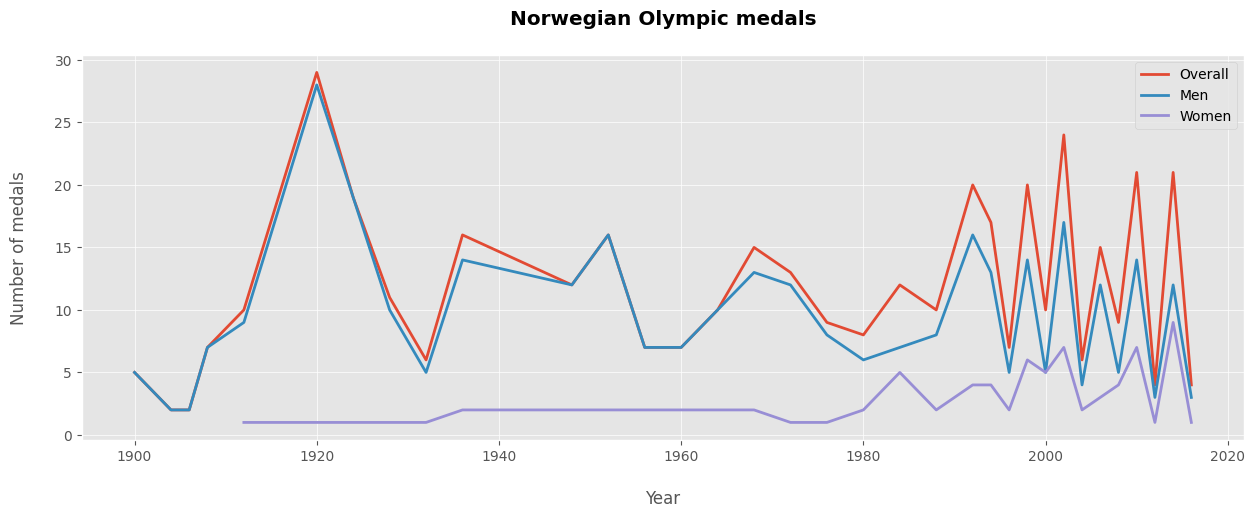

In [ ]:
medal_count_all = group_medals(no_medals, "Year").sort_values(by="Year")
medal_count_wom = no_medals[no_medals["Sex"] == "F"]
medal_count_wom = group_medals(medal_count_wom, "Year").sort_values(by="Year")
medal_count_men = no_medals[no_medals["Sex"] == "M"]
medal_count_men = group_medals(medal_count_men, "Year").sort_values(by="Year")
medal_count_men.columns[3]
plt.style.use("ggplot")
plt.figure(figsize=(15, 5))
sns.lineplot(data=medal_count_all, x="Year", y=medal_count_all.columns[3], label="Overall")
sns.lineplot(data=medal_count_men, x="Year", y=medal_count_men.columns[3], label="Men")
sns.lineplot(data=medal_count_wom, x="Year", y=medal_count_wom.columns[3], label="Women")
plt.title("Norwegian Olympic medals\n", fontweight="bold")
plt.ylabel("Number of medals\n")
plt.xlabel("\nYear")
plt.legend()
plt.show()

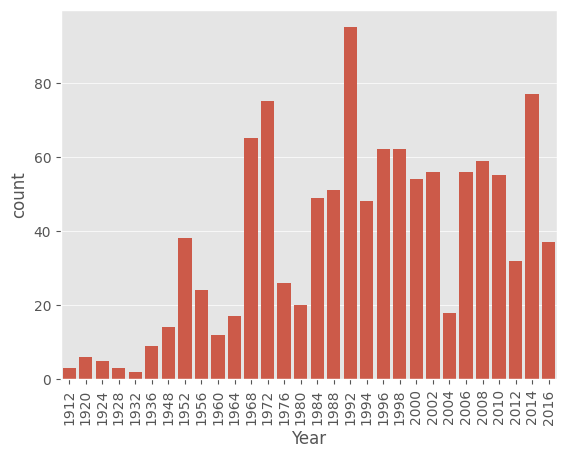

In [ ]:
no_women = no[no["Sex"] == "F"]
no_women = no_women[["Year", "Sex"]]
plt.style.use("ggplot")
sns.countplot(data=no_women, x="Year")
plt.xticks(rotation=90)
plt.show()


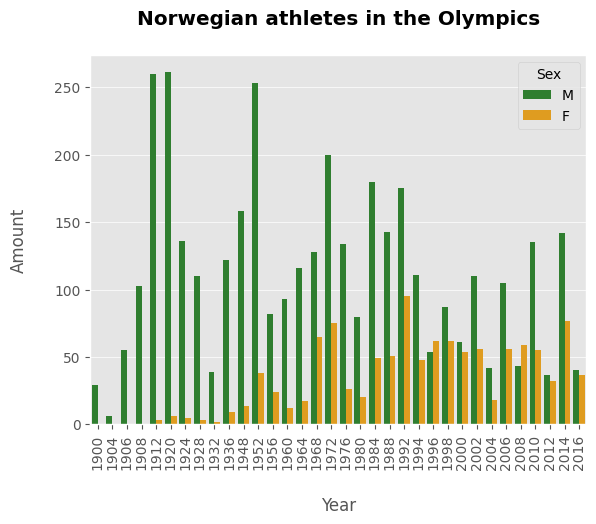

In [ ]:
no_genders = no.groupby(["Year","Sex"]).count().reset_index()
label_color = {"M": "forestgreen", "F": "orange"}
sns.barplot(data=no_genders,x="Year", y="ID", hue="Sex", palette=label_color)
plt.title("Norwegian athletes in the Olympics\n", fontweight="bold")
plt.ylabel("Amount\n")
plt.xlabel("\nYear")
plt.xticks(rotation=90)
plt.show()